# Kaggle MNIST

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
CAFFE_ROOT = '/home/xmf/BVLC_caffe/caffe/'     # please change it to your caffe root directory
import os, sys
CAFFE_PYTHON_DIR = os.path.join(CAFFE_ROOT, 'python')
print 'path of pycaffe {}'.format(CAFFE_PYTHON_DIR)
sys.path.insert(0, CAFFE_PYTHON_DIR)
import caffe
print 'caffe module is imported'

caffe.set_mode_gpu()   # if you don't have gpu, change gpu to cpu

IMAGE_SIZE = (28, 28,)

/home/xmf/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


path of pycaffe /home/xmf/BVLC_caffe/caffe/python
caffe module is imported


## 介绍 Introduction

MNIST是LeCun为了美国邮政系统手写数字识别问题而建立的数据集。自那以后，很多的学者提出了不同的方法不断提升识别精度，LeCun也针对这个问题提出了经典的卷积神经网络。这篇博客就是希望借助求解Kaggle平台上的MNIST竞赛，梳理使用Caffe实现基于卷积神经网络的手写数字识别的过程。

MNIST is a large database of handwritten digits established by LeCun. Many researchers have proposed different methods to increase the accurancy since then. LeCun gave a solution based on convolutional neural network, which is considered to be the first successful application of convolutional neural network case. This blog is to record how to use Caffe to implement a convolutional neural network for hand writing digits recongnization in Kaggle.

在[Kaggle](https://www.kaggle.com/c/digit-recognizer)的网站上，MNIST的数据是通过CSV文件给出的。对于训练所用文件train.csv，每行由28x28+1个数字组成。第一个数字为该训练样本对应的数字，后面的28x28个数字在0到255之间，代表训练样本的图像从上到下，从左到右各个像素的灰度值。测试所用文件test.csv则每行只有28x28个数字，相比训练样本，缺少了对应的标签。我们需要使用训练样本进行训练网络模型，再对应给出各个测试样例的对应预测标签，同样写入一个csv文件，并提交。

In [Kaggle](https://www.kaggle.com/c/digit-recognizer), the dataset is given by CSV files. For the training file train.csv, there are (28x28+1) numbers in each row. The first number is the label, and the following numbers are in the range [0, 255], giving the grayscale value for each pixel in the images. The testing file test.csv has 28x28 numbers in each row, lack of labels compared with training file. We need to train our model using the trainning samples and predict the labels for testing individuals. The results shoule be saved in a CSV file and submitted to the website.

## 获取数据 Data Acquirement

首先，我们需要在网上下载数据，分别是train.csv, test.csv，将它们放到 ./data/文件夹下。

First, we need to download dataset from website. Put them in ./data/ directory. 

我没有使用pandas解析文件，使用下面的函数可以将每一行除去标签之外的28x28个数转换为numpy中的二维数组。

I don't use pandas to parse the csv file. The following function can be uesd to parse the row excluding the label to 2D array in numpy.

In [10]:

def get_image(line):
    """
    get the 2D array from txt
    """
    data = [float(x) for x in line.split(',')]
    assert len(data) == IMAGE_SIZE[0] * IMAGE_SIZE[1]
    return np.array(data, dtype = np.float32).reshape(IMAGE_SIZE)
    

我们来随机选择3张训练用图像进行可视化。

Let‘s take a look at 3 images chosen randomly from the training list.

there are 3 example images of size (28x28).


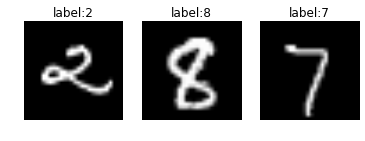

In [26]:
train_file = './data/train.csv'
test_file = './data/test.csv'
# read the trainning list from file
with open(train_file, 'r') as f:
    f.readline()    # skip the annotation
    train_list = f.readlines()
np.random.shuffle(train_list)
example_n = 3
examples = train_list[:example_n]
images = np.empty((example_n, ) + IMAGE_SIZE, dtype = np.uint8)
labels = np.empty(example_n, dtype = int)
for i, line in enumerate(examples):
    labels[i] = int(line[0])
    line = line[2:]   # skip the label and the first comma
    images[i] = get_image(line).astype(np.uint8)

print 'there are {0} example images of size ({1}x{2}).'.format(example_n, IMAGE_SIZE[0], IMAGE_SIZE[1])
plt.figure()
for i, im in enumerate(images):
    plt.subplot(1, example_n, i+1)
    plt.imshow(im, cmap = 'gray')
    plt.title('label:{}'.format(labels[i]))
    plt.axis('off')
    
plt.show()
    

## 构建卷积神经网络 Build CNN

在这个例子中，我只是很随便地设计了一个卷积网络。使用Caffe中的API将网络结构可视化，存储到./net文件夹下。

In this demo, I designed a vanilla CNN for this task. I use API in Caffe to visualize the net structure, and you can find the picture in ./net directory.

In [39]:
net_define_file = './net/train_val.prototxt'   # the prototxt file describing the structure of the network
phase = caffe.TRAIN                                        # training phase
output_file_name = './net/train_net.png'
import caffe.draw
from google.protobuf import text_format
from caffe.proto import caffe_pb2
net = caffe_pb2.NetParameter()
text_format.Merge(open(net_define_file).read(), net)
caffe.draw.draw_net_to_file(net, output_file_name, phase)


为了方便，我直接使用了HDF5作为数据的输入接口。将所有训练样本读取出来，存成HDF5文件。Caffe的数据输入层定义为HDF5Data就可以了。

For convinence, I used HDF5DataLayer as input interface of the net. So we need to generate HDF5 files from the raw data.

In [7]:
import h5py
import cv2
train_part = 0.8   # we use 80% of total samples as training

def get_h5_file(phase, lines, output_dir):
    """
    generate hdf5 files in output_dir directory
    """
    assert phase == 'train' or phase == 'val'
    print 'processing {0} part'.format(phase)
    print '-------------------------------' 
    total_number = len(lines)
    imgs = np.empty((total_number, 1,) +  IMAGE_SIZE, dtype = np.float32)
    labels = np.empty((total_number, 1), dtype = np.float32)
    cols = IMAGE_SIZE[0] * IMAGE_SIZE[1] + 1
    h5_file_name = os.path.join(output_dir, '{0}.h5'.format(phase))
    print 'output h5 file name:{0}'.format(h5_file_name)
    for i, line in enumerate(lines):
        line = line.strip()
        splited = line.split(',')
        assert len(splited) == cols
        data = [float(x) for x in splited[1:]]
        label = int(splited[0])
        assert 0 <= label <= 9 
        labels[i, 0] = label
        imgs[i] = np.array(data).reshape((1,) + IMAGE_SIZE)
        if (i +1) % 5000 == 0:
            print 'processed {0} images.'.format(i+1)
        imgs[i] -= 128.0
        imgs[i] /= 255.0
    with h5py.File(h5_file_name, 'w') as h:
        h.create_dataset('data', data = imgs)
        h.create_dataset('label', data = labels)
    with open(os.path.join(output_dir, '{0}_h5.txt').format(phase), 'w') as f:
        f.write(h5_file_name)
    print 'process {0} done.'.format(phase)
    
def process(csv_file, output_dir):
    """
    read samples from the csv file and save the data into hdf5 files 
    """
    name, ext = os.path.splitext(csv_file)
    assert ext == '.csv'
    with open(csv_file, 'r') as f:
        lines = f.readlines()
    lines = lines[1:]
    total_number = len(lines)
    print 'there are {0} images totally.'.format(total_number)
    
    np.random.shuffle(lines)
    train_number = int(total_number * train_part)
    val_number = total_number - train_number
    print 'total train samples: {0}'.format(train_number)
    print 'total val_sample: {0}'.format(val_number)
    train_lines = lines[:train_number]
    val_lines = lines[train_number:]
    assert len(val_lines) == val_number
    get_h5_file('train', train_lines, output_dir)
    get_h5_file('val', val_lines, output_dir)
    
file_name = './data/train.csv'
full_file_name = os.path.abspath(file_name)
path, _ = os.path.split(full_file_name)
process(full_file_name, path)

there are 42000 images totally.
total train samples: 33600
total val_sample: 8400
processing train part
-------------------------------
output h5 file name:/home/xmf/github/kaggle_mnist/data/train.h5
processed 5000 images.
processed 10000 images.
processed 15000 images.
processed 20000 images.
processed 25000 images.
processed 30000 images.
process train done.
processing val part
-------------------------------
output h5 file name:/home/xmf/github/kaggle_mnist/data/val.h5
processed 5000 images.
process val done.


## 训练 Train CNN

使用./scripts/train.sh脚本训练网络，注意修改其中caffe的路径。

Use train.sh to train the network. Please change CAFFE path.

In [5]:
!./scripts/train.sh

I0903 22:45:00.014075  3004 caffe.cpp:192] Using GPUs 0
I0903 22:45:00.021977  3004 caffe.cpp:197] GPU 0: GeForce GTX 960M
I0903 22:45:00.399430  3004 solver.cpp:48] Initializing solver from parameters: 
test_iter: 600
test_interval: 5000
base_lr: 0.001
display: 5000
max_iter: 20000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 20000
snapshot: 5000
snapshot_prefix: "./models/mnist"
solver_mode: GPU
device_id: 0
net: "./net/train_val.prototxt"
I0903 22:45:00.399696  3004 solver.cpp:91] Creating training net from net file: ./net/train_val.prototxt
I0903 22:45:00.400514  3004 net.cpp:313] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0903 22:45:00.400562  3004 net.cpp:313] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0903 22:45:00.400753  3004 net.cpp:49] Initializing net from parameters: 
name: "mnist-net"
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "HDF5Data"
  to

## 测试 Testing

经过训练，终于可以进行测试了。我们需要读入test.csv的内容，然后对于里面的每一个测试用例进行前向计算，得到对应的输出，作为预测。

After the training, we can test out model. We need to read the test imges and forward fill the net to get the predication labels.

In [8]:
def get_batch_images(lines):
    """
    get batch images for testing
    """
    total_size = len(lines)
    images = np.empty((total_size, 28, 28, 1), dtype = np.float32)
    for i, line in enumerate(lines):
        splited = line.strip().split(',')
        data = [float(x) for x in splited]
        images[i] = np.array(data).astype(np.float32).reshape((28, 28, 1))
    return images

def get_pred_label(cls, images, gt, verbose = True):
    """
    use cls to predict the label, gt is groundtruth for debugging
    When test, set gt = None, verbose = False
    """
    pred = cls.predict(images)
    n, c = pred.shape
    label = np.argmax(pred, axis = 1).astype(int)
    prob = pred[xrange(n), label]
    if verbose:
        for i in xrange(n):
            print 'idx {0}: label {1}, prob {2}, gt: {3}'.format(i, label[i], prob[i], gt[i])
    return label

def test(cls, csv_file, phase = 'test', head = None):
    """
    give the prediction of the images in csv_file
    """
    with open(csv_file, 'r') as f:
        lines = f.readlines()
    if head is None:
        head = 10
    lines = lines[1:]
    lines = lines[:head]
    imgs = np.empty((head, 28, 28, 1), dtype = np.float32)
    gt = np.empty((head, 1), dtype = int)
    for i, line in enumerate(lines):
        splited = line.strip().split(',')
        data = [float(x) for x in splited]
        gt[i] = int(data[0])
        imgs[i] = np.array(data[1:], dtype = np.float32).reshape((28, 28, 1))
    get_pred_label(cls, imgs, gt)

def get_final_tes_res(cls, input_csv_file, output_csv_file):
    """
    the function invoked in main function
    read test samples from input_csv_file
    write the prediction results to output_csv_file
    """
    with open(input_csv_file, 'r') as f:
        lines = f.readlines()
    lines = lines[1:]
    total_img_num = len(lines)
    batch = 1000
    groups = total_img_num / batch
    if total_img_num % batch:
        groups += 1
    print 'total test imge number: {0}'.format(total_img_num)
    print 'batch size: {0}, total group: {1}'.format(batch, groups)
    print '----------------------------'
    labels = np.empty((total_img_num, 1), dtype = int)

    for i in xrange(groups):
        start, end = batch*i, batch*(i+1)
        if i == groups-1:
            end = total_img_num
        line_batch = lines[start: end]
        images = get_batch_images(line_batch)
        pred_label = get_pred_label(cls, images, None, False)
        labels[start: end] = pred_label.reshape((-1, 1))
        print 'group {0} has been processed.'.format(i+1)
        
    with open(output_csv_file, 'w') as f:
        f.write('ImageId,Label\n')
        for i in xrange(total_img_num):
            f.write('{0},{1}\n'.format(i+1, labels[i, 0]))


class Classfier(caffe.Net):
    """
    Classifier extends caffe.Net for mnist class prediction
    """
    def __init__(self, model_file, weight_file):
        """
        initialization function, model file and weight file should
        be provided
        """
        caffe.Net.__init__(self, model_file, weight_file, caffe.TEST)
        self.input_size = (28, 28)
        in_ = self.inputs[0]
        self.transformer = caffe.io.Transformer(
            {in_: self.blobs[in_].data.shape for in_ in self.inputs})
        self.transformer.set_transpose(in_, (2, 0, 1))
        self.transformer.set_mean(in_, np.array([128.0]))
        self.transformer.set_input_scale(in_, 1.0/255)
    def predict(self, inputs):
        """
        predict classification probabilities of inputs
        """
        input_ = np.zeros((len(inputs),) + self.input_size + (1,), dtype = np.float32)
        for ix, in_ in enumerate(inputs):
            input_[ix] = caffe.io.resize_image(in_, self.input_size).reshape((28, 28, 1))

        # classify
        caffe_in = np.zeros(np.array(input_.shape)[[0, 3, 1, 2]], dtype=np.float32)
        for ix, in_ in enumerate(input_):
            caffe_in[ix] = self.transformer.preprocess(self.inputs[0], in_)
        out = self.forward_all(**{self.inputs[0]: caffe_in})
        pred = out[self.outputs[0]]

        return pred

In [9]:
model_file = './net/deploy.prototxt'
weight_file = './models/mnist_iter_20000.caffemodel'
cls = Classfier(model_file, weight_file)
  
test_csv = './data/test.csv'
output_file = './data/submit.csv'
get_final_tes_res(cls, test_csv, output_file)

total test imge number: 28000
batch size: 1000, total group: 28
----------------------------
group 1 has been processed.
group 2 has been processed.
group 3 has been processed.
group 4 has been processed.
group 5 has been processed.
group 6 has been processed.
group 7 has been processed.
group 8 has been processed.
group 9 has been processed.
group 10 has been processed.
group 11 has been processed.
group 12 has been processed.
group 13 has been processed.
group 14 has been processed.
group 15 has been processed.
group 16 has been processed.
group 17 has been processed.
group 18 has been processed.
group 19 has been processed.
group 20 has been processed.
group 21 has been processed.
group 22 has been processed.
group 23 has been processed.
group 24 has been processed.
group 25 has been processed.
group 26 has been processed.
group 27 has been processed.
group 28 has been processed.


## 提交结果 Submition

可以将结果提交到Kaggle的网站进行评比。我的模型精度为98.600%.

Submit your results to the website and get your rank! My model's accuracy is 98.600%.